# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/my_recommender/data')
!ls

Mounted at /content/gdrive
ml-1m-README.txt  movies.dat  ratings.dat  users.dat


# Load Files

In [3]:
# MovieLens 1M uses "::" as separator, which needs the python engine.
ratings_path = "ratings.dat"
movies_path  = "movies.dat"
users_path   = "users.dat"

ratings = pd.read_csv(
    ratings_path,
    sep="::",
    engine="python",
    names=["userId", "movieId", "rating", "timestamp"],
    encoding="latin-1"
)

movies = pd.read_csv(
    movies_path,
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"],
    encoding="latin-1"
)

users = pd.read_csv(
    users_path,
    sep="::",
    engine="python",
    names=["userId", "gender", "age", "occupation", "zip"],
    encoding="latin-1"
)

ratings.head(), movies.head(), users.head()


(   userId  movieId  rating  timestamp
 0       1     1193       5  978300760
 1       1      661       3  978302109
 2       1      914       3  978301968
 3       1     3408       4  978300275
 4       1     2355       5  978824291,
    movieId                               title                        genres
 0        1                    Toy Story (1995)   Animation|Children's|Comedy
 1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
 2        3             Grumpier Old Men (1995)                Comedy|Romance
 3        4            Waiting to Exhale (1995)                  Comedy|Drama
 4        5  Father of the Bride Part II (1995)                        Comedy,
    userId gender  age  occupation    zip
 0       1      F    1          10  48067
 1       2      M   56          16  70072
 2       3      M   25          15  55117
 3       4      M   45           7  02460
 4       5      M   25          20  55455)

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [6]:
users

,userId,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


# Quick EDA

Users: 6,040
Movies: 3,706
Ratings: 1,000,209
Sparsity: 95.5316%


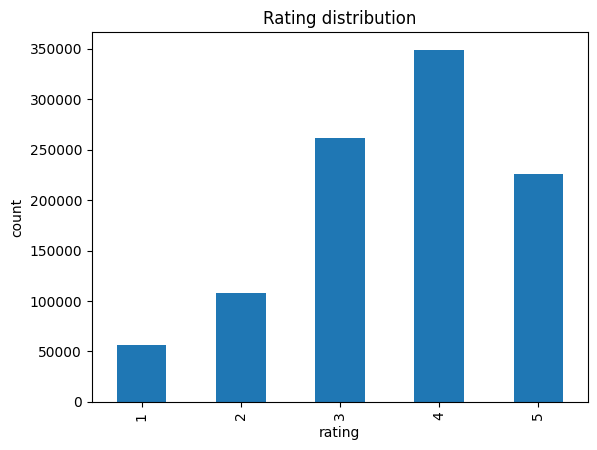

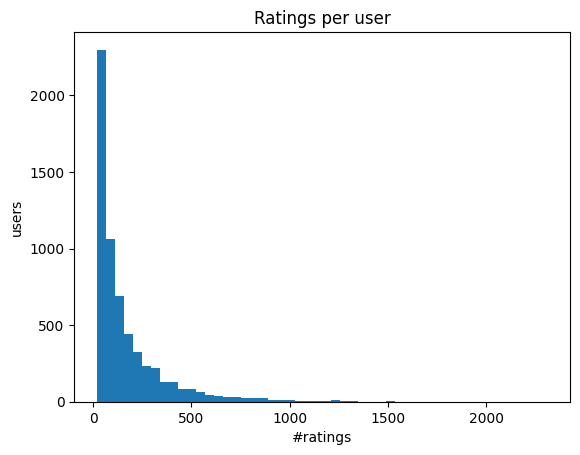

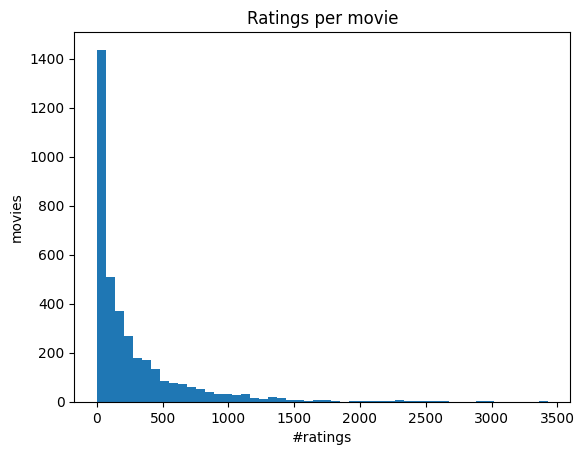

In [7]:
n_users = ratings["userId"].nunique()
n_items = ratings["movieId"].nunique()
n_ratings = len(ratings)

sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"Users: {n_users:,}")
print(f"Movies: {n_items:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Sparsity: {sparsity:.4%}")

ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("rating")
plt.ylabel("count")
plt.show()

user_counts = ratings.groupby("userId").size()
item_counts = ratings.groupby("movieId").size()

user_counts.plot(kind="hist", bins=50)
plt.title("Ratings per user")
plt.xlabel("#ratings")
plt.ylabel("users")
plt.show()

item_counts.plot(kind="hist", bins=50)
plt.title("Ratings per movie")
plt.xlabel("#ratings")
plt.ylabel("movies")
plt.show()


# SUPER EDA

## 1) Basic dataset integrity

Check:

no missing ratings

ID types

memory footprint

In [ ]:
ratings.info()
movies.info()
users.info()

ratings.isna().sum(), movies.isna().sum(), users.isna().sum()


## 2) Rating distribution (counts + proportions)

Insight to write down

Strong positivity bias (few 1–2 star ratings)

RMSE will be biased toward mid-high predictions

In [ ]:
rating_counts = ratings["rating"].value_counts().sort_index()
rating_props = rating_counts / rating_counts.sum()

fig, ax = plt.subplots(1, 2, figsize=(12,4))

rating_counts.plot(kind="bar", ax=ax[0])
ax[0].set_title("Rating counts")
ax[0].set_xlabel("rating")
ax[0].set_ylabel("count")

rating_props.plot(kind="bar", ax=ax[1])
ax[1].set_title("Rating proportions")
ax[1].set_xlabel("rating")
ax[1].set_ylabel("proportion")

plt.show()


## 3) Temporal analysis (very important, often skipped)

Insight

Confirms dataset spans multiple years

Justifies time-based split

In [ ]:
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["year"] = ratings["datetime"].dt.year

ratings.groupby("year").size().plot(marker="o")
plt.title("Ratings per year")
plt.xlabel("year")
plt.ylabel("count")
plt.show()


## 4) User activity distribution (long-tail)

Insight

Heavy long-tail

Many users have relatively few ratings

Explains cold-start challenges

In [ ]:
user_counts = ratings.groupby("userId").size()

user_counts.describe()


In [ ]:
plt.figure(figsize=(6,4))
plt.hist(user_counts, bins=50, log=True)
plt.title("Ratings per user (log scale)")
plt.xlabel("#ratings")
plt.ylabel("users")
plt.show()


## 5) Item popularity distribution (long-tail)

Insight

A few blockbuster movies dominate

CF will naturally favor popular items

In [ ]:
item_counts = ratings.groupby("movieId").size()

item_counts.describe()


In [ ]:
plt.figure(figsize=(6,4))
plt.hist(item_counts, bins=50, log=True)
plt.title("Ratings per movie (log scale)")
plt.xlabel("#ratings")
plt.ylabel("movies")
plt.show()


## 6) Sparsity analysis (quantified)

Insight

Matrix is extremely sparse (>95%)

Explains why MF works better than raw kNN

In [ ]:
n_users = ratings["userId"].nunique()
n_items = ratings["movieId"].nunique()
n_ratings = len(ratings)

sparsity = 1 - n_ratings / (n_users * n_items)

print(f"Matrix shape: {n_users} x {n_items}")
print(f"Sparsity: {sparsity:.2%}")


## 7) User-level rating behavior

Insight

Some users are generous, some are strict

Motivates user bias terms

In [ ]:
user_mean_ratings = ratings.groupby("userId")["rating"].mean()

plt.hist(user_mean_ratings, bins=30)
plt.title("Average rating per user")
plt.xlabel("avg rating")
plt.ylabel("users")
plt.show()


## 8) Movie-level rating behavior

Insight

Rating variance differs across movies

Popularity ≠ quality

In [ ]:
movie_mean_ratings = ratings.groupby("movieId")["rating"].mean()

plt.hist(movie_mean_ratings, bins=30)
plt.title("Average rating per movie")
plt.xlabel("avg rating")
plt.ylabel("movies")
plt.show()


## 9) Popularity vs rating quality

Insight

Popular movies are not always highly rated

Popularity bias can hurt personalization

In [ ]:
df_pop_quality = (
    ratings
    .groupby("movieId")
    .agg(
        count=("rating", "size"),
        mean_rating=("rating", "mean")
    )
)

plt.scatter(df_pop_quality["count"], df_pop_quality["mean_rating"], alpha=0.3)
plt.xscale("log")
plt.xlabel("#ratings (log)")
plt.ylabel("avg rating")
plt.title("Popularity vs quality")
plt.show()


## 10) Genre analysis (content signal)

Insight

Genre skew exists

Useful for hybrid / explainability later

In [ ]:
# explode genres
movie_genres = (
    movies
    .assign(genres=movies["genres"].str.split("|"))
    .explode("genres")
)

genre_counts = movie_genres["genres"].value_counts()

genre_counts.plot(kind="bar", figsize=(10,4))
plt.title("Movie count by genre")
plt.xlabel("genre")
plt.ylabel("count")
plt.show()


Optional: average rating per genre

In [ ]:
ratings_movies = ratings.merge(movie_genres, on="movieId")

genre_rating = ratings_movies.groupby("genres")["rating"].mean().sort_values()

genre_rating.plot(kind="bar", figsize=(10,4))
plt.title("Average rating by genre")
plt.xlabel("genre")
plt.ylabel("avg rating")
plt.show()


## 11) User demographics (optional, but nice)

plt.show()
Insight

Demographics exist but are coarse

You can justify not using them

In [ ]:
users["age"].value_counts().sort_index().plot(kind="bar")
plt.title("User age distribution")
plt.xlabel("age group code")
plt.ylabel("users")
plt.show()


Key EDA findings

Ratings are positively biased toward 3–4 stars

Interaction matrix is highly sparse (>95%)

Strong user and movie rating biases exist

Long-tail behavior is present on both users and items

Popularity does not imply high rating quality

Temporal structure justifies time-based evaluation